In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf
from datetime import date, timedelta
from statsmodels.regression.rolling import RollingOLS

from performance.performance_metrics import percentage_returns, sharpe_ratio
from performance.risk_free_rate import compute_risk_free_rate


sns.set_style("darkgrid")

# Data

Tickers:

    Futures:
    - "NG=F": natural gas front month
    - "CL=F": WTI crude oil front month
    - "BZ=F": Brent crude oil front month
    
    ETFs:
    - BNO: Brent crude (c. front month)
    - USO: WTI (c. front month)


Notes:
- Commodities futures & ETFs not currently beating buy and hold.
- 1d, days=365, end_date=2022-10-26, ticker1-"IVW", ticker2="SPY", lookback=60. Good.

In [34]:
today = date.today()
end_date = today.strftime("%Y-%m-%d")

interval = "1h"

interval_map = {
    "1m": timedelta(minutes=360),
    "1h": timedelta(hours=24*30),
    "1d": timedelta(days=365),   
}


start_date = (today - interval_map[interval]).strftime("%Y-%m-%d")

start_date, end_date

('2022-09-27', '2022-10-27')

In [35]:
ticker1 = "IVW"
ticker2 = "SPY"

# ticker1 = "NG=F"
# ticker2 = "BZ=F"

# ticker1 = "BZ=F"
# ticker2 = "CL=F"

# ticker1 = "BNO"
# ticker2 = "USO"

df1 = yf.download(ticker1, start=start_date, end=end_date, interval=interval)
df2 = yf.download(ticker2, start=start_date, end=end_date, interval=interval)

# df1.tail(2), df2.tail(2)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [36]:
# Use common index to align dates.
df = pd.DataFrame(index=df1.index)

df[f"close_{ticker1}"] = df1["Close"]
df[f"close_{ticker2}"] = df2["Close"]

df.index = pd.to_datetime(df.index)

# Drop missing entries
df.dropna(inplace=True)

df.tail()

,close_IVW,close_SPY
2022-10-26 12:30:00-04:00,60.619999,383.219910
2022-10-26 13:30:00-04:00,60.560001,382.769989
2022-10-26 14:30:00-04:00,60.480000,382.309998
2022-10-26 15:30:00-04:00,60.410000,382.079987
2022-10-26 16:00:00-04:00,60.439999,382.019989


# Plots to assess relationships in raw data

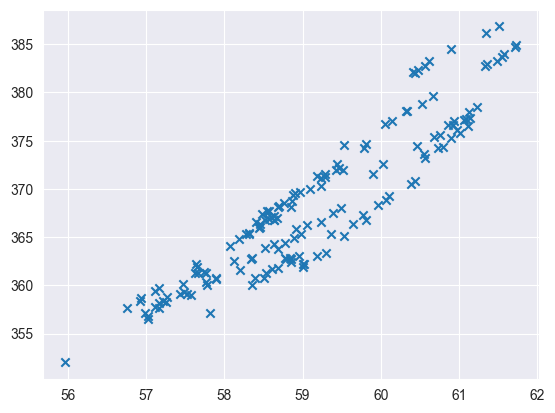

In [37]:
# Assess linearity
plt.scatter(df[f"close_{ticker1}"], df[f"close_{ticker2}"], marker="x")
plt.show()

<AxesSubplot: >

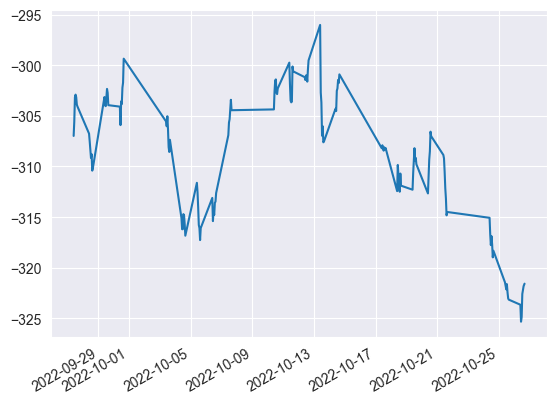

In [38]:
# Look at residuals of ticker1 - ticker2, i.e. with a fixed "hedge ratio" of -1. Hedge ratio will be fitted in the next step.
(df[f"close_{ticker1}"] - df[f"close_{ticker2}"]).plot()

# Model Fitting
https://www.statsmodels.org/dev/generated/statsmodels.regression.rolling.RollingOLS.html

<AxesSubplot: >

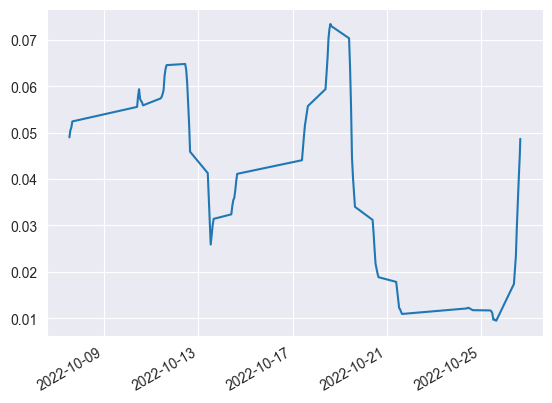

In [39]:
# Dependent variable.
X = df[f"close_{ticker1}"]

# Prepend a column of 1.0s to the df for y.
y = sm.add_constant(df[f"close_{ticker2}"])

# Number of periods to lookback for the rolling linear regression.
# Note: this number of periods in the output results -> NaN.
lookback_periods = 60
# lookback_periods = 100

model = RollingOLS(endog=X, exog=y, window=lookback_periods)

residuals = model.fit()
parameters = residuals.params.copy()

residuals.mse_resid.plot()

<AxesSubplot: >

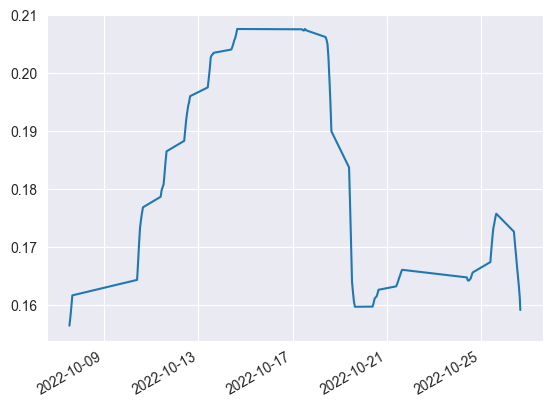

In [40]:
# Hedging Ratio between pairs
df["hedge_ratio"] = parameters[f"close_{ticker2}"]

# Drop the NaNs introduced by the lookback period
df.dropna(inplace=True)

df["hedge_ratio"].plot()

In [41]:
# Testing
# df["hedge_ratio"] = 0.0
# df["hedge_ratio"] = 1.0
# df["hedge_ratio"].plot()

# Plots to assess relationships in processed proposed portfolio

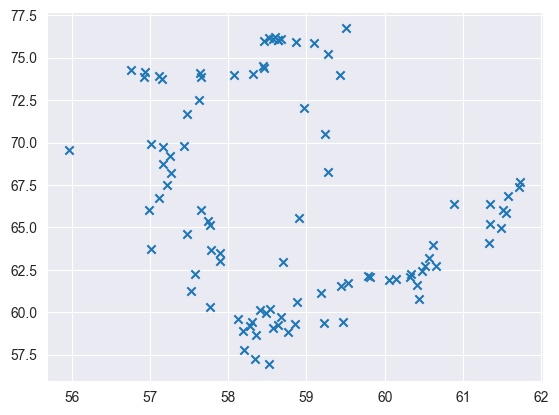

In [42]:
plt.scatter(df[f"close_{ticker1}"], df["hedge_ratio"] * df[f"close_{ticker2}"], marker="x")
plt.show()

# Feature Creation

In [43]:
# Spread
df["spread"] = df[f"close_{ticker1}"] - df["hedge_ratio"] * df[f"close_{ticker2}"]

# Compute Z-score of the spread -> entry/exit signals.
df["zscore"] = (df["spread"] - df["spread"].expanding().mean()) / df["spread"].expanding().std()

# 0th std term is 0.0 -> divide by 0 creates NaN in 0th row.
df.dropna(inplace=True)

# Long, Short and Exit Signals

In [44]:
# When to long, short, or exit the market
z_entry_threshold = 2.0
z_exit_threshold = 1.0

# Cast bools -> floats
df["long"] = 1.0*(df["zscore"] <= -z_entry_threshold)
df["short"] = 1.0*(df["zscore"] >= z_entry_threshold)

df["exit"] = 1.0*(np.abs(df["zscore"]) <= z_exit_threshold)

In [45]:
# Signals to demonstrate when to propagate positions forward:
# - Stay long if: Z_exit_threshold < Z < Z_entry_threshold
# - Stay short if: Z_entry_threshold < Z < Z_exit_threshold
df["long_market"] = 0.0  # Must be float
df["short_market"] = 0.0  # Must be float

# Track whether to be long or short while iterating through each timestep
long_market = 0.0  # Must be float
short_market = 0.0  # Must be float

# Calculate when to be in the market via holding a long or short position, and when to exit the market.
# Hard to vectorise: note how `long_market` and `short_market` values are carried over in each loop iteration.
for i, row in enumerate(df.iterrows()):
    if row[1]["long"] == 1.0:
        long_market = 1            
    if row[1]["short"] == 1.0:
        short_market = 1
    if row[1]["exit"] == 1.0:
        long_market = 0
        short_market = 0
        
    # Assign 1/0 to long_market/short_market to indicate when to stay in a position
    df.iloc[i]["long_market"] = long_market
    df.iloc[i]["short_market"] = short_market

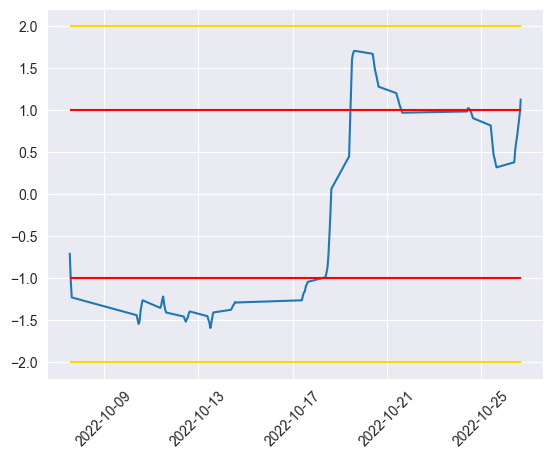

In [46]:
plt.plot(df.index, df["zscore"])
plt.hlines(
    [z_entry_threshold, -z_entry_threshold, z_exit_threshold, -z_exit_threshold],
    colors=["gold", "gold", "red", "red"],
    xmin=df.index[0],
    xmax=df.index[-1],
)
plt.xticks(rotation=45)
plt.show()

# Portfolio Returns

In [47]:
# pf: portfolio
df_pf = pd.DataFrame(index=df.index)

df_pf["positions"] = df["long_market"] - df["short_market"]

df_pf[f"close_{ticker1}"] = -1.0 * df[f"close_{ticker1}"] * df_pf["positions"]
df_pf[f"close_{ticker2}"] = df[f"close_{ticker2}"] * df_pf["positions"]

df_pf["total"] = df_pf[f"close_{ticker1}"] + df_pf[f"close_{ticker2}"]

In [48]:
# df_pf[df_pf["returns"] == -1.0]  # explore

In [49]:
# Calculate simple percentage returns
df_pf["returns"] = df_pf["total"].pct_change()

df_pf["returns"].fillna(0.0, inplace=True)
df_pf["returns"].replace([np.inf, -np.inf], 0.0, inplace=True)
df_pf["returns"].replace(-1.0, 0.0, inplace=True)

# Accumulate returns across each time period
df_pf["returns"] = (1.0 + df_pf["returns"]).cumprod()


df_pf[f"returns_{ticker1}"] = (df[f"close_{ticker1}"].pct_change()+1.0).cumprod()
df_pf[f"returns_{ticker2}"] = (df[f"close_{ticker2}"].pct_change()+1.0).cumprod()


df_pf.tail()

,positions,close_IVW,close_SPY,total,returns,returns_IVW,returns_SPY
2022-10-26 12:30:00-04:00,0.0,-0.0,0.0,0.0,1.0,1.039081,1.056634
2022-10-26 13:30:00-04:00,0.0,-0.0,0.0,0.0,1.0,1.038053,1.055393
2022-10-26 14:30:00-04:00,0.0,-0.0,0.0,0.0,1.0,1.036682,1.054125
2022-10-26 15:30:00-04:00,0.0,-0.0,0.0,0.0,1.0,1.035482,1.053491
2022-10-26 16:00:00-04:00,0.0,-0.0,0.0,0.0,1.0,1.035996,1.053325


<AxesSubplot: >

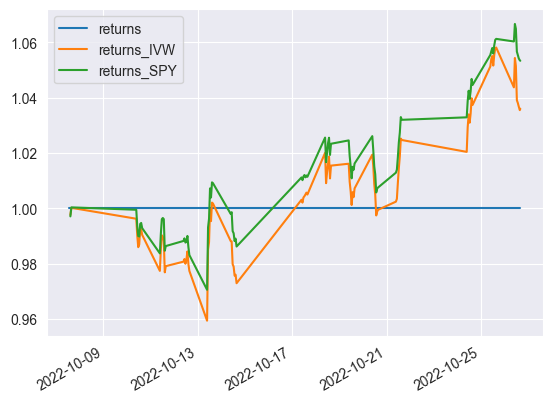

In [50]:
df_pf[["returns", f"returns_{ticker1}", f"returns_{ticker2}"]].plot()

In [51]:
df_pf["returns"].describe()

count    95.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: returns, dtype: float64